In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In this notebook, we look at how many visits we could have if we put standard # of visits in WFD, and then split the remainder over the rest of our "big sky" (-90 to +32 deg).  

So first: estimate the total number of visits available. 

In [2]:
# Total approximate number of visits in opsim:
#totalNvis = 2400000  # with snaps (2x15s exposures/visit)
totalNvis = 2600000  # without snaps (1x30s/visit)
# Let's say we can play with 90% of these visits
percentTotal = 0.90
totalNvis *= percentTotal
print("The number of visits available is %d (%.2fM)" % (totalNvis, totalNvis/1000000))

The number of visits available is 2340000 (2.34M)


Now count visits in WFD and visits in rest of "big sky". 

In [3]:
# Read the field list.
fields = pd.read_csv('field_list.csv')
# what does the field list look like?
fields[0:5]

,fieldId,fov,ra,dec,gl,gb,el,eb
0,1,3.5,0.000000,-90.000000,-57.068082,-27.128251,-89.931210,-66.561358
1,2,3.5,180.000000,-87.568555,-57.663825,-24.756541,-96.024547,-66.442665
2,3,3.5,324.000429,-87.568550,-54.980423,-28.712449,-85.262622,-65.058907
3,4,3.5,35.999571,-87.568550,-58.164147,-29.359810,-84.695237,-67.907706
4,5,3.5,252.001105,-87.568547,-54.748581,-25.862125,-91.659618,-64.238559


In [4]:
# Select fields with declination between -90 and 32 -- our "big sky" footprint
bigsky = fields.query('(dec >= -90) and (dec <= 32)') 
wfd = fields.query('(dec >= -72.25) and (dec <= 12.4) and ((gb >= 15) or (gb <= -15))')
bigNotWFD = bigsky.query('((dec < -72.25) or (dec > 12.4)) or ((gb < 15) and (gb > -15))')

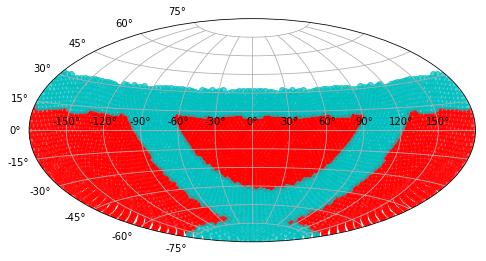

In [5]:
# Plot the fields so we can check what this footprint looks like.
def radec2project(ra, dec):
    return (np.radians(ra) - np.pi, np.radians(dec))

fig = plt.figure(figsize=(8, 8))
ax = plt.subplot(111, projection="aitoff")
x, y = radec2project(bigsky.ra, bigsky.dec)
#ax.scatter(x, y, alpha=0.5)
x, y = radec2project(wfd.ra, wfd.dec)
ax.scatter(x, y, alpha=0.7, color='r')
x, y = radec2project(bigNotWFD.ra, bigNotWFD.dec)
ax.scatter(x, y, alpha=0.7, color='c')
plt.grid(True)

In [6]:
# fancyplot
import numpy.ma as ma
import lsst.sims.maf.slicers as slicers
import lsst.sims.maf.plots as plots
from matplotlib.patches import Ellipse

def plotFields(fieldRA, fieldDec):
    # fieldRA / fieldDec are dictionaries - key=prop 
    slicer = slicers.OpsimFieldSlicer()
    fignum = None
    colorlist = [[1, 1, 0], [.5, 0, .5], [0, .25, .5], [0, 1, 0],
                  [0, 0, 0], [1, 0, 0], [.5, .5, 1]]
    ci = 0
    colors = {}
    for prop in fieldRA:
        print(prop)
        # Modify slicer so we can use it for plotting.
        slicer.slicePoints['ra'] = np.radians(fieldRA[prop])
        slicer.slicePoints['dec'] = np.radians(fieldDec[prop])
        fieldLocs = ma.MaskedArray(data=np.empty(len(fieldRA[prop]), object),
                                   mask=np.zeros(len(fieldRA[prop]), bool),
                                   fill_value=-99)
        colors[prop] = [colorlist[ci][0], colorlist[ci][1], colorlist[ci][2], 0.4]
        ci += 1
        if ci == len(colorlist):
            ci = 0
        for i in range(len(fieldRA[prop])):
            fieldLocs.data[i] = colors[prop]
        skymap = plots.BaseSkyMap()
        fignum = skymap(fieldLocs, slicer,
                        {'metricIsColor': True, 'bgcolor': 'lightgray', 'raCen': 0, 'figsize': (10, 8)},
                        fignum=fignum)
    plt.figure(fignum)
    labelcolors = []
    labeltext = []
    for prop in fieldRA:
        el = Ellipse((0, 0), 0.03, 0.03,
                     fc=(colors[prop][0], colors[prop][1], colors[prop][2]),
                     alpha=colors[prop][3])
        labelcolors.append(el)
        labeltext.append(prop.rstrip('.conf'))
    plt.legend(labelcolors, labeltext, loc=(0.85, 0.9), fontsize='smaller')
    plt.show()

wfd
other


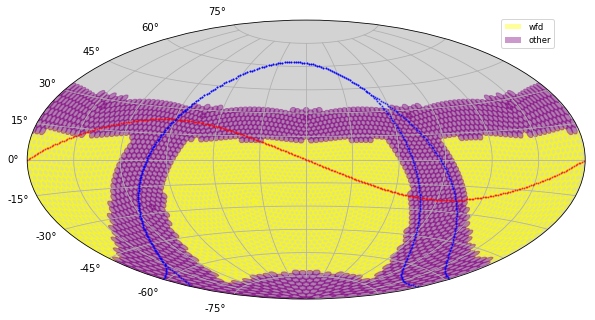

In [7]:
fieldra = {}
fielddec = {}
fieldra['wfd'] = wfd.ra
fielddec['wfd'] = wfd.dec
fieldra['other'] = bigNotWFD.ra
fielddec['other'] = bigNotWFD.dec
plotFields(fieldra, fielddec)

In [8]:
# How many fields are included in this "big sky" version of the survey?
print("The number of fields in the total footprint is %d" % (len(bigsky)))
print("The number of fields in the WFD footprint is %d" % (len(wfd)))
print("The number of fields in the rest of the footprint is %d" % (len(bigNotWFD)))

The number of fields in the total footprint is 4066
The number of fields in the WFD footprint is 2290
The number of fields in the rest of the footprint is 1776


So how many visits could we potentially have per field: if we sent 825 visits/field to WFD and then split the rest among the other fields?

In [30]:
wfdvisits = len(wfd) * 825
print("Reserving %d visits for WFD" % (wfdvisits))
availNvis = totalNvis - wfdvisits
print("Available visits for other surveys: %d (%.2fM)" % (availNvis, availNvis/1000000))
# Exact number of visits per field
visPerField = availNvis / len(bigNotWFD)
# Round the number of visits per field to an integer
visPerField = int(round(visPerField))
# And recalculate what this means for the totalNvis -- if the total # changed too much, maybe round down
propTotal = visPerField * len(bigNotWFD)
print("This corresponds to %d visits per field (%.2f/year)" % (visPerField, (visPerField/10.)))
print("This implies a total number of visits required of %d (compared to original estimate of %d): %.2f%s change"
     % (propTotal + wfdvisits, totalNvis, float(propTotal + wfdvisits - totalNvis) / totalNvis * 100.0, "%"))
print("Ratio WFD (%.2fM) to (all) total visits (%.2fM): %.2f" % (wfdvisits/1000000, 
                                                                 totalNvis/percentTotal/1000000,
                                                                 wfdvisits/(totalNvis/percentTotal)))

Reserving 1889250 visits for WFD
Available visits for other surveys: 450750 (0.45M)
This corresponds to 254 visits per field (25.40/year)
This implies a total number of visits required of 2340354 (compared to original estimate of 2340000): 0.02% change
Ratio WFD (1.89M) to (all) total visits (2.60M): 0.73


In [12]:
# visits per month (assume season = 5 months /year) per year (assume 8 years 'on')
visPerField/5/10

5.08

Let's add some estimate on the coadded depths you could achieve.

This requires assuming a dark sky, zenith, typical single visit depth and then scaling by the number of visits in each filter. 

In [13]:
# Current expected performance
single_m5 = {'u': 23.98, 'g': 24.91, 'r': 24.42, 'i': 23.97, 'z': 23.38, 'y': 22.47}

In [36]:
# How should we divide the visits? (per field) 
fractionsPerFilter = {'u': 0.1, 'g': 0.1, 'r': 0.20, 'i': 0.20, 'z': 0.20, 'y': 0.20}
fracSum = 0
for f, v in fractionsPerFilter.items():
    fracSum += v
    print('Fraction in %s: %.3f' % (f, v))
print("Total: %.3f" % (fracSum))

Fraction in u: 0.100
Fraction in g: 0.100
Fraction in r: 0.200
Fraction in i: 0.200
Fraction in z: 0.200
Fraction in y: 0.200
Total: 1.000


In [38]:
# Make actual numbers per filter .. jiggle as necessary. (note that you could set these by hand instead)
visPerFilter = {}
fieldTotal = 0
for f in fractionsPerFilter:
    visPerFilter[f] = int(round(fractionsPerFilter[f] * visPerField))
    fieldTotal += visPerFilter[f]
    print('Visits in %s: %d' % (f, visPerFilter[f]))
print('Total per field: %d (compared to potential %d per field previously calculated)' %(fieldTotal, visPerField))
# Jiggle by hand ..
visPerFilter['r'] += 0
fieldTotal = 0
for f in visPerFilter:
    fieldTotal += visPerFilter[f]
    print('Visits in %s: %d' % (f, visPerFilter[f]))
print('After re-jiggering: Total per field: %d (compared to potential %d per field previously calculated)' %(fieldTotal, visPerField))

Visits in u: 25
Visits in g: 25
Visits in r: 51
Visits in i: 51
Visits in z: 51
Visits in y: 51
Total per field: 254 (compared to potential 254 per field previously calculated)
Visits in u: 25
Visits in g: 25
Visits in r: 51
Visits in i: 51
Visits in z: 51
Visits in y: 51
After re-jiggering: Total per field: 254 (compared to potential 254 per field previously calculated)


So calculate the scaled coadded depth per filter, per field. Note that this assumes all observations are taken under the same "dark-sky, zenith" conditions.

In [39]:
# Current expected performance
single_m5 = {'u': 23.98, 'g': 24.91, 'r': 24.42, 'i': 23.97, 'z': 23.38, 'y': 22.47}

In [40]:
coadd_m5 = {}
for f in visPerFilter:
    coadd_m5[f] = single_m5[f] + 2.5 * np.log10(np.sqrt(visPerFilter[f]))
    print("Coadded depth in %s: %.2f" % (f, coadd_m5[f]))

Coadded depth in u: 25.73
Coadded depth in g: 26.66
Coadded depth in r: 26.55
Coadded depth in i: 26.10
Coadded depth in z: 25.51
Coadded depth in y: 24.60


Given "realistic" opsim conditions, we would expect some typical offsets from these dark-sky, zenith coadded depths. 
Using the WFD region from kraken\_2026 we can calculate these expected offsets:

In [41]:
# Using estimates from kraken_2026:
kraken_single_m5 = {'u': 23.78, 'g': 24.81, 'r': 24.35, 'i': 23.92, 'z': 23.34, 'y': 22.45}
kraken_visPerFilter = {'u': 64, 'g': 90, 'r': 206, 'i': 204, 'z': 186, 'y': 188}
opsimCoaddM5 = {'u': 25.65, 'g': 27.15, 'r': 27.20, 'i': 26.62, 'z': 25.72, 'y': 24.91}
kraken_coadd_m5 = {}
offset = {}
for f in visPerFilter:
    kraken_coadd_m5[f] = kraken_single_m5[f] + 2.5 * np.log10(np.sqrt(kraken_visPerFilter[f]))
    offset[f] = kraken_coadd_m5[f] - opsimCoaddM5[f]
    print("Coadded depth in %s: %.2f - correction is %.2f" % (f, kraken_coadd_m5[f], offset[f]))

Coadded depth in u: 26.04 - correction is 0.39
Coadded depth in g: 27.25 - correction is 0.10
Coadded depth in r: 27.24 - correction is 0.04
Coadded depth in i: 26.81 - correction is 0.19
Coadded depth in z: 26.18 - correction is 0.46
Coadded depth in y: 25.29 - correction is 0.38


In [42]:
saved_offsets = {'u': 0.39, 'g': 0.10, 'r': 0.04, 'i': 0.19, 'z': 0.46, 'y': 0.38}

In [43]:
# Means we might achieve these coadded values:
for f in visPerFilter:
    coadd_m5[f] = single_m5[f] + 2.5 * np.log10(np.sqrt(visPerFilter[f])) - saved_offsets[f]
    print("Coadded depth in %s: %.2f" % (f, coadd_m5[f]))

Coadded depth in u: 25.34
Coadded depth in g: 26.56
Coadded depth in r: 26.51
Coadded depth in i: 25.91
Coadded depth in z: 25.05
Coadded depth in y: 24.22
